In [ ]:
import sys
!{sys.executable} -m pip install pandas scikit-learn matplotlib numpy

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [43]:
x = pd.read_csv('../data/game_data_v5.csv')
x.head(3)

,away_team,away_score,away_team_xwoba_diff,away_lineup_xwoba,away_team_xfip,away_starter_xfip,away_close_win_pct,away_run_diff,home_team,home_score,home_team_xwoba_diff,home_lineup_xwoba,home_team_xfip,home_starter_xfip,home_close_win_pct,home_run_diff
0,SF,5,-0.01395,0.324688,4.3175,3.664927,0.481528,-50.85,AZ,6,0.00290,0.311853,4.0145,3.477347,0.543823,58.35
1,CHC,3,0.01790,0.318530,3.9005,3.572162,0.577740,151.35,STL,4,0.02085,0.313119,3.9985,3.609118,0.486630,68.65
2,NYY,3,0.02180,0.328305,3.8120,3.460087,0.485525,123.20,TB,7,0.00115,0.312432,4.2200,3.293424,0.430893,-15.95


In [44]:
# add output columns (scores) to separate dataset
y = pd.DataFrame({'away_score': x['away_score'], 'home_score': x['home_score']})
# y = pd.DataFrame({'home_win': x['home_score'] > x['away_score']})['home_win']

# remove output columns and team names from input dataset
x = x.drop(['away_score', 'home_score', 'away_team', 'home_team'], axis=1)

In [28]:
# split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)

In [ ]:
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=500, max_depth=7, max_features='sqrt', random_state=100))
model.get_params()

In [45]:
model_cv = GridSearchCV(estimator=MultiOutputRegressor(RandomForestRegressor()),
                        param_grid={
                            'estimator__n_estimators': [200, 250, 300, 350, 400, 450, 500, 550, 600],
                            'estimator__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                        },
                        # scoring={},
                        # refit='',
                        cv=5)

In [47]:
# model_cv.fit(x, y)
# model_cv.cv_results_

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [31]:
pred = model.predict(x_test)
pred[0:3]

array([[5.87366244, 4.1044473 ],
       [4.09750971, 5.19421163],
       [3.94772177, 4.4186202 ]])

In [32]:
y_test.head(3)

,away_score,home_score
3273,4,1
6461,6,5
10848,7,8


In [33]:
num_correct = 0
num_incorrect = 0

for i in range(len(pred)):
    away_score_pred = pred[i][0]
    home_score_pred = pred[i][1]
    away_score_actual = y_test['away_score'].iloc[i]
    home_score_actual = y_test['home_score'].iloc[i]

    pred_result = 1 if home_score_pred > away_score_pred else 0 # where 1 = home team wins
    actual_result = 1 if home_score_actual > away_score_actual else 0

    # pred_result = pred[i]
    # actual_result = y_test.iloc[i]
    
    if pred_result == actual_result:
        num_correct += 1
    else:
        num_incorrect += 1

print(f'Correct: {num_correct}')
print(f'Incorrect: {num_incorrect}')
print(f'W/L accuracy: {(num_correct / (num_correct + num_incorrect))*100}%')

Correct: 2286
Incorrect: 1584
W/L accuracy: 59.06976744186046%


In [34]:
mean_squared_error(y_test, pred)

np.float64(9.988183215573418)

In [35]:
model.score(x_test, y_test)

0.04407825978986929

In [36]:
y_test.describe()

,away_score,home_score
count,3870.000000,3870.000000
mean,4.527132,4.576486
std,3.289851,3.174630
min,0.000000,0.000000
25%,2.000000,2.000000
50%,4.000000,4.000000
75%,6.000000,6.000000
max,24.000000,29.000000


In [37]:
pred_df = pd.DataFrame(pred)
pred_df.describe()

,0,1
count,3870.000000,3870.000000
mean,4.521836,4.620715
std,0.725424,0.565388
min,2.755161,2.846652
25%,4.003669,4.194559
50%,4.431281,4.609577
75%,5.036144,5.045061
max,8.769025,6.644851


Correlation coefficient (away team): r=0.20585870425659936
Correlation coefficient (home team): r=0.2187251110829884


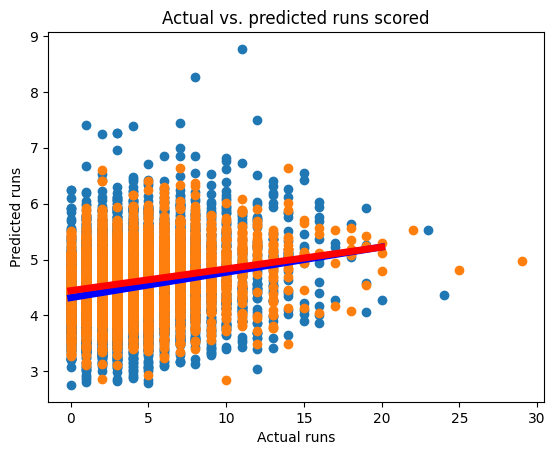

In [38]:
# drawing a scatterplot with regression line
# https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/

plt.scatter(y_test['away_score'], pred_df[0])
plt.scatter(y_test['home_score'], pred_df[1])


m_away, b_away = np.polyfit(y_test['away_score'], pred_df[0], deg=1)
x_away = np.linspace(0, 20, num=1000)

plt.plot(x_away, m_away * x_away + b_away, color='b', lw=5)

r_away = np.corrcoef(y_test['away_score'], pred_df[0])
print(f'Correlation coefficient (away team): r={r_away[0][1]}')


m_home, b_home = np.polyfit(y_test['home_score'], pred_df[1], deg=1)
x_home = np.linspace(0, 20, num=1000)

plt.plot(x_home, m_home * x_home + b_home, color='r', lw=5)

r_home = np.corrcoef(y_test['home_score'], pred_df[1])
print(f'Correlation coefficient (home team): r={r_home[0][1]}')


plt.xlabel('Actual runs')
plt.ylabel('Predicted runs')
plt.title('Actual vs. predicted runs scored')

plt.show()

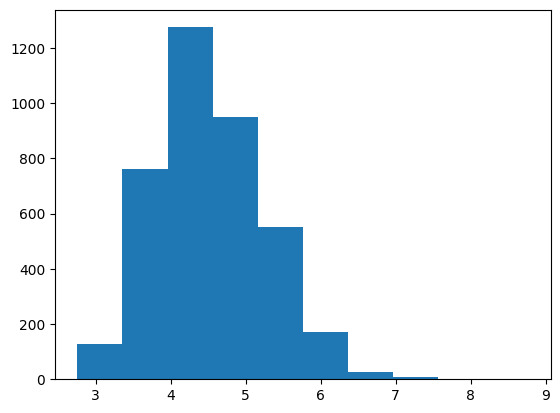

In [39]:
plt.hist(pred_df[0])
plt.show()

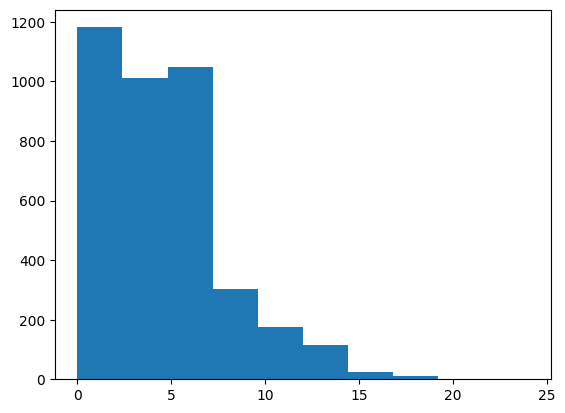

In [40]:
plt.hist(y_test['away_score'])
plt.show()

In [64]:
0.19371346717243468 ** 2

0.03752490736396593

In [78]:
# why is standard deviation so low? -> should it be that way?
# try a logistic regression for comparison

# experiment with monthly stats
# grid search cv


# experiment with past 2 season data - pretty much the same
# build a histogram of runs predicted
# figure out rookie average stats